# Change Directory

In [69]:
import os

# Check current working directory
print("Current directory:", os.getcwd())

# Change the working directory
os.chdir('./Cuckoo/PrincipalCurve/') # Change to your own directory

# Confirm the change
print("New directory:", os.getcwd())



# Principal Curves Comparison: Hastie & Stuetzle vs PSO

## 1. Setup and Dependencies

In [3]:

# Cell 1: Import libraries and basic setup
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import UnivariateSpline, splev, splprep
import time
import pandas as pd
import os

print("Current working directory:", os.getcwd())

# Check for necessary files
if os.path.exists('elvis.npy'):
    print("✓ Found elvis.npy file")
else:
    print("✗ elvis.npy file not found")

print("Basic modules imported successfully!")

Current working directory: /Users/elviscui/Downloads/UCI-Postdoc/Cuckoo/PrincipalCurve
✓ Found elvis.npy file
Basic modules imported successfully!


## 2. Data Generation Functions

In [6]:
# Cell 2: Data generation functions (core components from SimulationSettings.ipynb)
def generate_all_datasets():
    """Generate all test datasets"""
    np.random.seed(42)
    datasets = {}
    
    # === Spiral I ===
    n = 120
    omega_true = np.sort(np.random.uniform(-1, 1, n))
    
    def P_spiral1(lam):
        return np.stack([
            np.sin(2 * np.pi * lam),
            np.exp(-lam),
            np.cos(2 * np.pi * lam)
        ], axis=1)
    
    def dP_spiral1(lam):
        return np.stack([
            2 * np.pi * np.cos(2 * np.pi * lam),
            -np.exp(-lam),
            -2 * np.pi * np.sin(2 * np.pi * lam)
        ], axis=1)
    
    data = P_spiral1(omega_true)
    noise_sd = 0.05
    normal_vec = np.random.randn(n, 3)
    tangent_vec = dP_spiral1(omega_true)
    normal_noise = normal_vec - (normal_vec * tangent_vec).sum(axis=1, keepdims=True) * tangent_vec
    normal_noise = normal_noise / np.linalg.norm(normal_noise, axis=1, keepdims=True)
    Y_spiral1 = data + noise_sd * normal_noise
    datasets['Spiral I'] = (Y_spiral1, data)
    
    # === Spiral II ===
    omega_true = np.sort(np.random.uniform(0, 2, n))
    
    def P_spiral2(omega):
        return np.stack([omega,
                         2*omega*np.cos(6*omega),
                         2*omega*np.sin(6*omega)], axis=1)
    
    def tangent_spiral2(omega):
        dP = np.stack([
            np.ones_like(omega),
            2*np.cos(6*omega) - 12*omega*np.sin(6*omega),
            2*np.sin(6*omega) + 12*omega*np.cos(6*omega)
        ], axis=1)
        norms = np.linalg.norm(dP, axis=1, keepdims=True)
        return dP / norms
    
    data = P_spiral2(omega_true)
    noise_sd = 0.1
    normal_vec = np.random.randn(n, 3)
    tangent_vec = tangent_spiral2(omega_true)
    normal_noise = normal_vec - (normal_vec * tangent_vec).sum(axis=1, keepdims=True) * tangent_vec
    normal_noise = normal_noise / np.linalg.norm(normal_noise, axis=1, keepdims=True)
    Y_spiral2 = data + noise_sd * normal_noise
    datasets['Spiral II'] = (Y_spiral2, data)
    
    # === Heart ===
    lambda_true = np.sort(np.random.uniform(1e-10, 2*np.pi, n))
    
    def P_heart(lmbda):
        x = 16 * np.sin(lmbda)**3
        y = 13 * np.cos(lmbda) - 5 * np.cos(2*lmbda) - 2 * np.cos(3*lmbda) - np.cos(4*lmbda)
        z = np.abs(np.sin(lmbda))
        return np.stack([x, y, z], axis=1)
    
    def tangent_heart(lmbda):
        dx = 48 * np.sin(lmbda)**2 * np.cos(lmbda)
        dy = (-13 * np.sin(lmbda)
              + 10 * np.sin(2*lmbda)
              + 6 * np.sin(3*lmbda)
              + 4 * np.sin(4*lmbda))
        dz = np.cos(lmbda) * np.sign(np.sin(lmbda))
        dP = np.stack([dx, dy, dz], axis=1)
        norms = np.linalg.norm(dP, axis=1, keepdims=True)
        return dP / norms
    
    data = P_heart(lambda_true)
    noise_sd = 0.1
    normal_vec = np.random.randn(n, 3)
    tangent_vec = tangent_heart(lambda_true)
    normal_noise = normal_vec - (normal_vec * tangent_vec).sum(axis=1, keepdims=True) * tangent_vec
    normal_noise = normal_noise / np.linalg.norm(normal_noise, axis=1, keepdims=True)
    Y_heart = data + noise_sd * normal_noise
    datasets['Heart'] = (Y_heart, data)
    
    # === Butterfly ===
    lmbda = np.sort(np.random.uniform(0, 1, n))
    
    def P_butterfly(lmbda, scale=2):
        t = lmbda * scale * np.pi
        r = np.exp(np.cos(t)) - 2 * np.cos(4*t) - np.sin(t/12)**5
        x = np.sin(t) * r
        y = np.cos(t) * r
        return np.stack([x, y], axis=1)
    
    def dP_butterfly(lmbda, scale=2):
        t = lmbda * scale * np.pi
        dt_dl = scale * np.pi
        r = np.exp(np.cos(t)) - 2 * np.cos(4*t) - np.sin(t/12)**5
        dr_dt = -np.exp(np.cos(t)) * np.sin(t) + 8 * np.sin(4*t) - 5 * np.sin(t/12)**4 * np.cos(t/12)/12
        dx = np.cos(t)*r*dt_dl + np.sin(t)*dr_dt*dt_dl
        dy = -np.sin(t)*r*dt_dl + np.cos(t)*dr_dt*dt_dl
        return np.stack([dx, dy], axis=1)
    
    curve = P_butterfly(lmbda)
    dP_butt = dP_butterfly(lmbda)
    tangent = dP_butt / np.linalg.norm(dP_butt, axis=1, keepdims=True)
    normal = np.stack([-tangent[:,1], tangent[:,0]], axis=1)
    sigma = 0.08
    Y_butterfly = curve + sigma * np.random.randn(n,1) * normal
    curve_butterfly = P_butterfly(np.linspace(0, 1, n))
    datasets['Butterfly'] = (Y_butterfly, curve_butterfly)
    
    # === Pedal ===
    def P_petal(lmbda, scale=1):
        t = lmbda * scale * np.pi
        x = 2 * np.cos(3*t) * np.cos(t)
        y = 2 * np.cos(3*t) * np.sin(t)
        return np.stack([x, y], axis=1)
    
    def dP_petal(lmbda, scale=1):
        t = lmbda * scale * np.pi
        dt_dl = scale * np.pi
        dx = -2 * 3 * np.sin(3*t) * np.cos(t) * dt_dl + 2 * np.cos(3*t) * -np.sin(t) * dt_dl
        dy = -2 * 3 * np.sin(3*t) * np.sin(t) * dt_dl + 2 * np.cos(3*t) * np.cos(t) * dt_dl
        return np.stack([dx, dy], axis=1)
    
    curve = P_petal(lmbda)
    dP = dP_petal(lmbda)
    tangent = dP / np.linalg.norm(dP, axis=1, keepdims=True)
    normal = np.stack([-tangent[:,1], tangent[:,0]], axis=1)
    sigma = 0.05
    Y_pedal = curve + sigma * np.random.randn(n,1) * normal
    curve_pedal = P_petal(np.linspace(0, 1, n))
    datasets['Pedal'] = (Y_pedal, curve_pedal)
    
    # === Elvis ===
    try:
        points = np.load('elvis.npy') / 15
        tck, u = splprep([points[:,0], points[:,1]], s=3, per=False)
        
        def P_elvis(lmbda):
            return np.array(splev(lmbda, tck)).T
        
        def dP_elvis(lmbda):
            return np.array(splev(lmbda, tck, der=1)).T
        
        lmbda = np.sort(np.random.uniform(0, 1, n))
        curve_elvis = P_elvis(lmbda)
        tangent = dP_elvis(lmbda)
        tangent_norm = tangent / np.linalg.norm(tangent, axis=1, keepdims=True)
        normal = np.stack([-tangent_norm[:,1], tangent_norm[:,0]], axis=1)
        sigma = 0.5
        Y_elvis = curve_elvis + sigma * np.random.randn(n, 1) * normal
        curve_elvis_true = P_elvis(np.linspace(0, 1, n))
        datasets['Elvis'] = (Y_elvis, curve_elvis_true)
        
    except:
        print("Warning: Unable to load Elvis data, skipping this scenario")
    
    return datasets

# Generate all datasets
datasets = generate_all_datasets()
print(f"Successfully generated {len(datasets)} datasets:")
for name in datasets.keys():
    print(f"  - {name}")

Successfully generated 6 datasets:
  - Spiral I
  - Spiral II
  - Heart
  - Butterfly
  - Pedal
  - Elvis


## 3. PSO Algorithm Implementation

In [9]:
# Cell 3: PSO-related functions (from principalcurve_test.ipynb)
def eval_smoother(smooths, omega):
    """Return fitted values for given omega"""
    Yhat = np.stack([s(omega) for s in smooths], axis=1)
    return Yhat

def fit_smoother(omega, Y, s=2):
    """Fit smoothers"""
    idx = np.argsort(omega)
    omega_sorted = omega[idx]
    Y_sorted = Y[idx]
    smooths = []
    for j in range(Y.shape[1]):
        us = UnivariateSpline(omega_sorted, Y_sorted[:, j], s=s)
        smooths.append(us)
    return smooths

def loss_fn(omega, Y, rho=1, penalty_large=1e6):
    """Loss function"""
    if np.any(np.diff(np.sort(omega)) <= 0):
        return penalty_large
    smooths = fit_smoother(omega, Y)
    Yhat = eval_smoother(smooths, omega)
    mse = np.mean(np.sum((Y - Yhat)**2, axis=1))
    penalty = rho * np.sum(np.abs(np.diff(np.sort(omega))))
    return mse + penalty

def pso_objective(X, Y=None, rho=1):
    """PSO objective function"""
    losses = []
    for omega in X:
        omega = np.clip(omega, 0, 1)
        losses.append(loss_fn(omega, Y, rho))
    return np.array(losses)

# Simplified PSO implementation (avoiding pyswarms dependency)
class SimplePSO:
    def __init__(self, n_particles=20, dimensions=100, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.dimensions = dimensions
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
    def optimize(self, objective_func, bounds, iters=100):
        lower_bound, upper_bound = bounds
        
        # Initialize particle positions and velocities
        positions = np.random.uniform(lower_bound, upper_bound, (self.n_particles, self.dimensions))
        velocities = np.random.uniform(-1, 1, (self.n_particles, self.dimensions))
        
        # Calculate initial fitness
        fitness = objective_func(positions)
        
        # Personal best and global best
        pbest_positions = positions.copy()
        pbest_fitness = fitness.copy()
        gbest_idx = np.argmin(fitness)
        gbest_position = positions[gbest_idx].copy()
        gbest_fitness = fitness[gbest_idx]
        
        for iteration in range(iters):
            # Update velocity and position
            r1, r2 = np.random.random((2, self.n_particles, self.dimensions))
            
            velocities = (self.w * velocities + 
                         self.c1 * r1 * (pbest_positions - positions) +
                         self.c2 * r2 * (gbest_position - positions))
            
            positions = positions + velocities
            positions = np.clip(positions, lower_bound, upper_bound)
            
            # Calculate new fitness
            fitness = objective_func(positions)
            
            # Update personal best
            better_mask = fitness < pbest_fitness
            pbest_positions[better_mask] = positions[better_mask]
            pbest_fitness[better_mask] = fitness[better_mask]
            
            # Update global best
            current_best_idx = np.argmin(fitness)
            if fitness[current_best_idx] < gbest_fitness:
                gbest_position = positions[current_best_idx].copy()
                gbest_fitness = fitness[current_best_idx]
        
        return gbest_fitness, gbest_position

def estimate_principal_curve_pso(Y, rho=1, max_iter=60, n_particles=20, verbose=True):
    """Estimate principal curves using PSO"""
    n = len(Y)
    
    bounds = (np.zeros(n), np.ones(n))
    
    def scenario_objective(X):
        return pso_objective(X, Y=Y, rho=rho)
    
    # Run PSO
    pso = SimplePSO(n_particles=n_particles, dimensions=n)
    cost, omega_opt = pso.optimize(scenario_objective, bounds, iters=max_iter)
    
    # Fit final smoother
    omega_opt = np.sort(omega_opt)
    smooths_final = fit_smoother(omega_opt, Y)
    curve_est = eval_smoother(smooths_final, omega_opt)
    
    if verbose:
        print(f"PSO completed, final cost: {cost:.4f}")
    
    # Create convergence history
    history = [cost] * max_iter
    
    return curve_est, omega_opt, cost, history

print("PSO algorithm module loaded successfully!")

PSO algorithm module loaded successfully!


## Cuckoo Algorithm Implementation

In [12]:
def cuckoo_objective(X, Y=None, rho=1):
    """Objective function for Cuckoo Search"""
    losses = []
    for omega in X:
        omega = np.clip(omega, 0, 1)
        losses.append(loss_fn(omega, Y, rho))
    return np.array(losses)
    
# Simplified Cuckoo Search implementation
class SimpleCuckoo:
    def __init__(self, n_nests=20, dimensions=100, pa=0.25, alpha=0.01):
        self.n_nests = n_nests
        self.dimensions = dimensions
        self.pa = pa
        self.alpha = alpha

    def _levy_flight(self, beta=1.5):
        """Generate a Lévy flight step"""
        sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
                 (np.math.gamma((1 + beta) / 2) * beta * 2**((beta - 1)/2)))**(1/beta)
        u = np.random.normal(0, sigma, self.dimensions)
        v = np.random.normal(0, 1, self.dimensions)
        step = u / (np.abs(v)**(1/beta))
        return step

    def optimize(self, objective_func, bounds, iters=100):
        lower_bound, upper_bound = bounds

        # Initialize nests
        nests = np.random.uniform(lower_bound, upper_bound, (self.n_nests, self.dimensions))
        fitness = objective_func(nests)
        best_idx = np.argmin(fitness)
        best_nest = nests[best_idx].copy()
        best_score = fitness[best_idx]

        for iteration in range(iters):
            # Generate new solutions using Lévy flights
            new_nests = np.zeros_like(nests)
            for i in range(self.n_nests):
                step = self._levy_flight()
                new_pos = nests[i] + self.alpha * step * (nests[i] - best_nest)
                new_pos = np.clip(new_pos, lower_bound, upper_bound)
                new_nests[i] = new_pos

            # Evaluate new nests
            new_fitness = objective_func(new_nests)
            improved = new_fitness < fitness
            nests[improved] = new_nests[improved]
            fitness[improved] = new_fitness[improved]

            # Abandon some nests and replace with random positions
            n_abandon = int(self.pa * self.n_nests)
            if n_abandon > 0:
                random_nests = np.random.uniform(lower_bound, upper_bound, (n_abandon, self.dimensions))
                worst_indices = np.argsort(-fitness)[:n_abandon]
                nests[worst_indices] = random_nests
                fitness[worst_indices] = objective_func(nests[worst_indices])

            # Update the global best nest
            current_best_idx = np.argmin(fitness)
            if fitness[current_best_idx] < best_score:
                best_score = fitness[current_best_idx]
                best_nest = nests[current_best_idx].copy()

        return best_score, best_nest


def estimate_principal_curve_cuckoo(Y, rho=1, max_iter=60, n_nests=20, verbose=True):
    """Estimate principal curves using Cuckoo Search"""
    n = len(Y)
    bounds = (np.zeros(n), np.ones(n))

    def scenario_objective(X):
        return cuckoo_objective(X, Y=Y, rho=rho)

    # Run Cuckoo Search
    cuckoo = SimpleCuckoo(n_nests=n_nests, dimensions=n)
    cost, omega_opt = cuckoo.optimize(scenario_objective, bounds, iters=max_iter)

    # Fit final smoother
    omega_opt = np.sort(omega_opt)
    smooths_final = fit_smoother(omega_opt, Y)
    curve_est = eval_smoother(smooths_final, omega_opt)

    if verbose:
        print(f"Cuckoo Search completed, final cost: {cost:.4f}")

    # Create convergence history
    history = [cost] * max_iter

    return curve_est, omega_opt, cost, history

print("Cuckoo Search algorithm module loaded successfully!")

Cuckoo Search algorithm module loaded successfully!


## 4. Hastie & Stuetzle Algorithm Implementation

In [15]:
# Cell 4: Hastie & Stuetzle algorithm implementation
def manual_pca(X, n_components=1):
    """Simple PCA implementation to avoid sklearn dependency"""
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    return eigenvectors[:, idx[:n_components]], eigenvalues[idx[:n_components]]

class HastiePrincipalCurves:
    def __init__(self, span=0.5, max_iter=30, tol=1e-6):
        self.span = span
        self.max_iter = max_iter
        self.tol = tol
        self.convergence_history = []
        
    def _initialize_curve(self, X):
        """Initialize curve using first principal component"""
        principal_component, _ = manual_pca(X, n_components=1)
        X_centered = X - np.mean(X, axis=0)
        projections = np.dot(X_centered, principal_component).flatten()
        sorted_indices = np.argsort(projections)
        sorted_X = X[sorted_indices]
        
        distances = np.zeros(len(sorted_X))
        for i in range(1, len(sorted_X)):
            distances[i] = distances[i-1] + np.linalg.norm(sorted_X[i] - sorted_X[i-1])
        return sorted_X, distances
    
    def _project_to_curve(self, X, curve_points):
        """Project points to curve"""
        projections = []
        for point in X:
            distances = [np.linalg.norm(point - cp) for cp in curve_points]
            closest_idx = np.argmin(distances)
            projections.append(closest_idx)
        return np.array(projections)
    
    def _smooth_coordinates(self, indices, X):
        """Smooth coordinates"""
        n_coords = X.shape[1]
        smoothed_coords = np.zeros_like(X)
        
        for j in range(n_coords):
            try:
                window_size = max(3, int(len(X) * self.span))
                for i in range(len(X)):
                    start_idx = max(0, i - window_size//2)
                    end_idx = min(len(X), i + window_size//2 + 1)
                    smoothed_coords[i, j] = np.mean(X[start_idx:end_idx, j])
            except:
                smoothed_coords[:, j] = X[:, j]
        return smoothed_coords
    
    def _compute_distance(self, X, curve_points):
        """Compute total distance"""
        total_distance = 0
        for point in X:
            distances = [np.linalg.norm(point - cp) for cp in curve_points]
            total_distance += min(distances)**2
        return total_distance
    
    def fit(self, X):
        """Fit principal curve"""
        X = np.array(X)
        curve_points, _ = self._initialize_curve(X)
        prev_distance = float('inf')
        
        for iteration in range(self.max_iter):
            try:
                projections = self._project_to_curve(X, curve_points)
                new_curve_points = self._smooth_coordinates(projections, X)
                current_distance = self._compute_distance(X, new_curve_points)
                self.convergence_history.append(current_distance)
                
                relative_change = abs(prev_distance - current_distance) / (prev_distance + 1e-10)
                if relative_change < self.tol:
                    break
                    
                curve_points = new_curve_points
                prev_distance = current_distance
                
            except Exception as e:
                print(f"Error in iteration {iteration}: {e}")
                break
        
        self.curve_points_ = curve_points
        self.final_distance_ = current_distance
        return self

print("Hastie & Stuetzle algorithm module loaded successfully!")

Hastie & Stuetzle algorithm module loaded successfully!


## 5. Evaluation Metrics

In [47]:
# Cell 5: Quantitative comparison metrics including L2 distance
def compute_metrics(Y, curve_true, curve_hastie, curve_cuckoo):
    """Compute comprehensive comparison metrics"""
    
    def avg_distance_to_curve(data, curve):
        """Average distance from data points to curve"""
        if len(curve) == 0:
            return float('inf')
        distances = []
        for point in data:
            dists = [np.linalg.norm(point - cp) for cp in curve]
            distances.append(min(dists))
        return np.mean(distances)
    
    def curve_to_true_distance(estimated_curve, true_curve):
        """Average distance from estimated curve to true curve"""
        if len(estimated_curve) == 0 or len(true_curve) == 0:
            return float('inf')
        distances = []
        for point in estimated_curve:
            dists = [np.linalg.norm(point - tp) for tp in true_curve]
            distances.append(min(dists))
        return np.mean(distances)
    
    def l2_distance_aligned(curve_est, curve_true):
        """
        L2 distance between aligned curves
        1/n * Σ[(x_hat - x)² + (y_hat - y)² + (z_hat - z)²]
        """
        if len(curve_est) == 0 or len(curve_true) == 0:
            return float('inf')
        
        # Align curves by resampling to same number of points
        n_points = min(len(curve_est), len(curve_true))
        
        # Resample both curves to n_points
        if len(curve_est) != n_points:
            indices = np.linspace(0, len(curve_est)-1, n_points).astype(int)
            curve_est_aligned = curve_est[indices]
        else:
            curve_est_aligned = curve_est
            
        if len(curve_true) != n_points:
            indices = np.linspace(0, len(curve_true)-1, n_points).astype(int)
            curve_true_aligned = curve_true[indices]
        else:
            curve_true_aligned = curve_true
        
        # Calculate L2 distance
        diff = curve_est_aligned - curve_true_aligned
        l2_dist = np.mean(np.sum(diff**2, axis=1))
        return l2_dist
    
    def hausdorff_distance(curve1, curve2):
        """
        Hausdorff distance (symmetric measure)
        max(max_min_dist(curve1, curve2), max_min_dist(curve2, curve1))
        """
        if len(curve1) == 0 or len(curve2) == 0:
            return float('inf')
        
        def directed_hausdorff(c1, c2):
            max_min_dist = 0
            for p1 in c1:
                min_dist = min([np.linalg.norm(p1 - p2) for p2 in c2])
                max_min_dist = max(max_min_dist, min_dist)
            return max_min_dist
        
        return max(directed_hausdorff(curve1, curve2), 
                  directed_hausdorff(curve2, curve1))
    
    def curve_length(curve):
        """Calculate curve length"""
        if len(curve) < 2:
            return 0
        return sum(np.linalg.norm(curve[i] - curve[i-1]) for i in range(1, len(curve)))
    
    # Calculate all metrics
    metrics = {
        # Original metrics
        'hastie_to_true': curve_to_true_distance(curve_hastie, curve_true),
        'cuckoo_to_true': curve_to_true_distance(curve_cuckoo, curve_true),
        'hastie_data_fit': avg_distance_to_curve(Y, curve_hastie),
        'cuckoo_data_fit': avg_distance_to_curve(Y, curve_cuckoo),
        
        # New L2 distance (your advisor's suggestion)
        'hastie_l2': l2_distance_aligned(curve_hastie, curve_true),
        'cuckoo_l2': l2_distance_aligned(curve_cuckoo, curve_true),
        
        # Hausdorff distance (symmetric)
        'hastie_hausdorff': hausdorff_distance(curve_hastie, curve_true),
        'cuckoo_hausdorff': hausdorff_distance(curve_cuckoo, curve_true),
        
        # Length metrics
        'true_length': curve_length(curve_true),
        'hastie_length': curve_length(curve_hastie),
        'cuckoo_length': curve_length(curve_cuckoo),
    }
    
    # Length ratios
    if metrics['true_length'] > 1e-10:
        metrics['hastie_length_ratio'] = metrics['hastie_length'] / metrics['true_length']
        metrics['cuckoo_length_ratio'] = metrics['cuckoo_length'] / metrics['true_length']
    else:
        metrics['hastie_length_ratio'] = 1.0
        metrics['cuckoo_length_ratio'] = 1.0
    
    return metrics

print("Enhanced metric calculation functions defined")

Enhanced metric calculation functions defined


## 6. Experimental Comparison

In [49]:
# Cell 6: Run comparison experiments
# Using datasets generated in Cell 2
results = {}

for name, (Y, curve_true) in datasets.items():
    print(f"\n=== {name} ===")
    
    try:
        # Hastie method
        print("Running Hastie & Stuetzle algorithm...")
        start_time = time.time()
        hastie_pc = HastiePrincipalCurves(span=0.3, max_iter=20)
        hastie_pc.fit(Y)
        hastie_time = time.time() - start_time
        
        # PSO/Cuckoo method
        print("Running Cuckoo algorithm...")
        start_time = time.time()
        # curve_pso, omega_pso, cost_pso, history_pso = estimate_principal_curve_pso(
        #     Y, rho=1, max_iter=60, verbose=False
        # )
        curve_cuckoo, omega_cuckoo, cost_cuckoo, history_cuckoo = estimate_principal_curve_cuckoo(
            Y, rho=1, max_iter=80, verbose=False
        )
        cuckoo_time = time.time() - start_time
        
        # Calculate metrics
        metrics = compute_metrics(Y, curve_true, hastie_pc.curve_points_, curve_cuckoo)
        
        # Store results
        results[name] = {
            'Y': Y,
            'curve_true': curve_true,
            'curve_hastie': hastie_pc.curve_points_,
            'curve_cuckoo': curve_cuckoo,
            'hastie_time': hastie_time,
            'cuckoo_time': cuckoo_time,
            'hastie_distance': hastie_pc.final_distance_,
            'cuckoo_distance': cost_cuckoo,
            'metrics': metrics,
            'hastie_convergence': hastie_pc.convergence_history,
            'cuckoo_convergence': history_cuckoo
        }
        
        print(f"Hastie: {hastie_time:.2f}s, distance: {hastie_pc.final_distance_:.4f}")
        print(f"Cuckoo: {cuckoo_time:.2f}s, distance: {cost_cuckoo:.4f}")
        
    except Exception as e:
        print(f"Error processing {name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nCompleted! Successfully processed {len(results)} scenarios")


=== Spiral I ===
Running Hastie & Stuetzle algorithm...
Running Cuckoo algorithm...


/var/folders/lm/mj3c35ss0td8hpys17lq9_b80000gn/T/ipykernel_3397/2422747184.py:76: RuntimeWarning: invalid value encountered in scalar divide
  relative_change = abs(prev_distance - current_distance) / (prev_distance + 1e-10)
/var/folders/lm/mj3c35ss0td8hpys17lq9_b80000gn/T/ipykernel_3397/990456482.py:19: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
/var/folders/lm/mj3c35ss0td8hpys17lq9_b80000gn/T/ipykernel_3397/990456482.py:20: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1 + beta) / 2) * beta * 2**((beta - 1)/2)))**(1/beta)
/var/folders/lm/mj3c35ss0td8hpys17lq9_b80000gn/T/ipykernel_3397/4174214973.py:14: UserWarning: 
A theoretically impossible result was found during the iteration
proc

Hastie: 0.11s, distance: 31.0253
Cuckoo: 8.46s, distance: 0.9527

=== Spiral II ===
Running Hastie & Stuetzle algorithm...
Running Cuckoo algorithm...
Hastie: 0.10s, distance: 167.8760
Cuckoo: 9.39s, distance: 0.9332

=== Heart ===
Running Hastie & Stuetzle algorithm...
Running Cuckoo algorithm...
Hastie: 0.10s, distance: 1546.8177
Cuckoo: 10.58s, distance: 0.9467

=== Butterfly ===
Running Hastie & Stuetzle algorithm...
Running Cuckoo algorithm...
Hastie: 0.10s, distance: 106.6233
Cuckoo: 6.97s, distance: 0.9230

=== Pedal ===
Running Hastie & Stuetzle algorithm...
Running Cuckoo algorithm...
Hastie: 0.10s, distance: 20.4068
Cuckoo: 6.45s, distance: 0.9127

=== Elvis ===
Running Hastie & Stuetzle algorithm...
Running Cuckoo algorithm...
Hastie: 0.10s, distance: 6526.9734
Cuckoo: 8.94s, distance: 0.9253

Completed! Successfully processed 6 scenarios


## 7. Visual Comparison

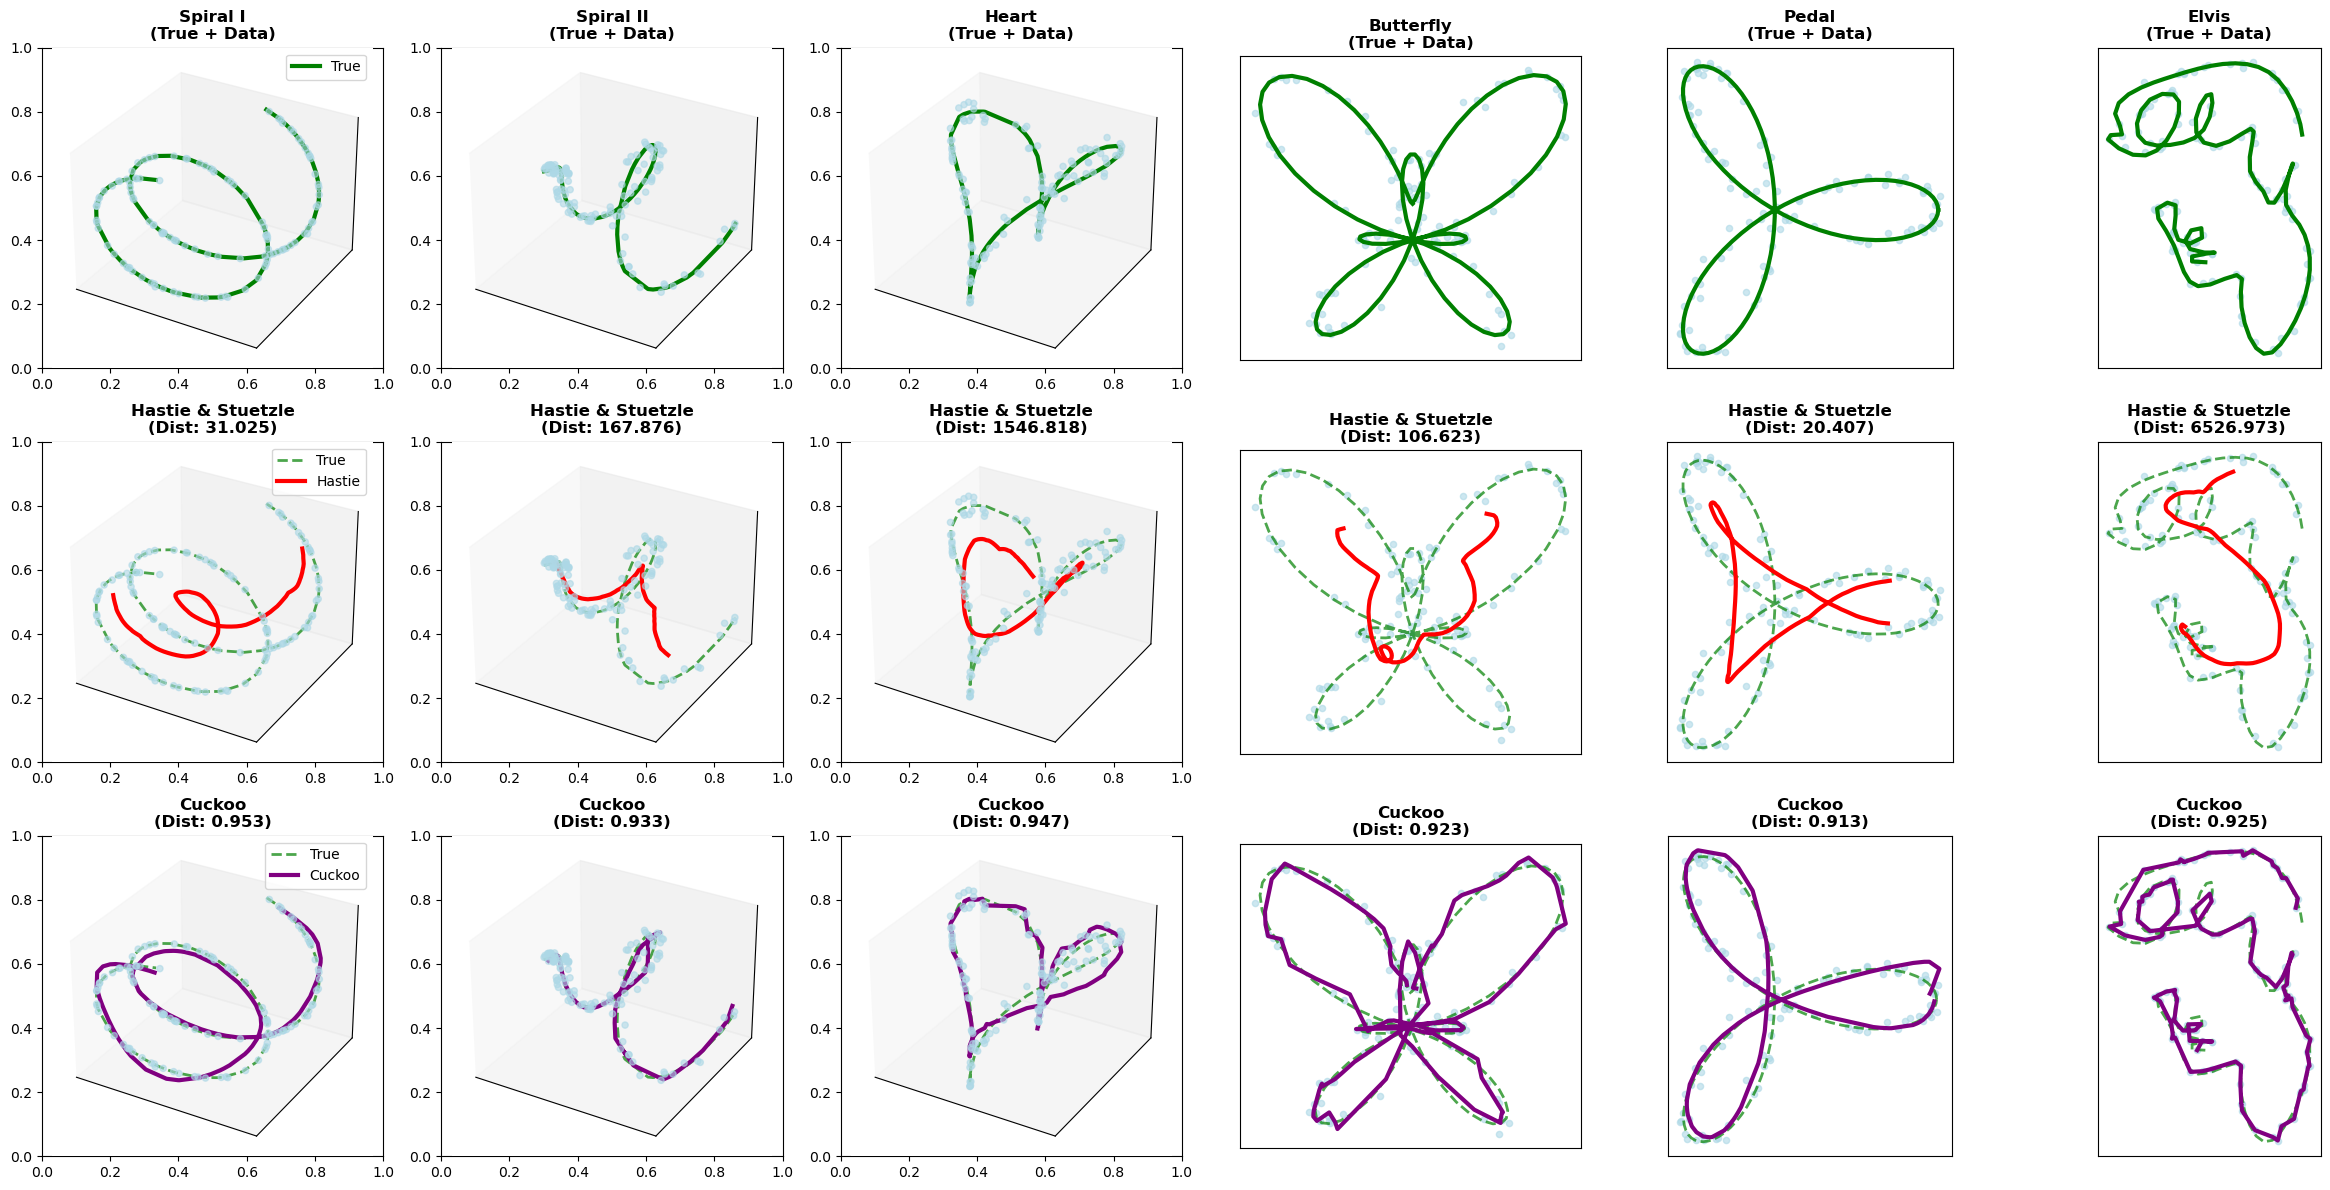

In [67]:
# Cell 7: Three-method visual comparison
from mpl_toolkits.mplot3d import Axes3D

n_results = len(results)
fig, axes = plt.subplots(3, n_results, figsize=(4*n_results, 12))

for i, (name, result) in enumerate(results.items()):
    Y = result['Y']
    curve_true = result['curve_true']
    curve_hastie = result['curve_hastie']
    curve_cuckoo = result['curve_cuckoo']
    
    # Determine if 3D data
    is_3d = curve_true.shape[1] == 3
    
    # Original data + true curve
    if is_3d:
        ax = fig.add_subplot(3, n_results, i + 1, projection='3d')
        ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], alpha=0.6, c='lightblue', s=20)
        ax.plot(curve_true[:, 0], curve_true[:, 1], curve_true[:, 2], 'g-', linewidth=3, label='True')
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    else:
        ax = axes[0, i]
        ax.scatter(Y[:, 0], Y[:, 1], alpha=0.6, c='lightblue', s=20)
        ax.plot(curve_true[:, 0], curve_true[:, 1], 'g-', linewidth=3, label='True')
        ax.set_aspect('equal')
        ax.set_xticks([]); ax.set_yticks([])
        if name == 'Elvis':
            ax.invert_yaxis()
    
    ax.set_title(f'{name}\n(True + Data)', fontsize=12, weight='bold')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()
    
    # Hastie results
    if is_3d:
        ax = fig.add_subplot(3, n_results, i + n_results + 1, projection='3d')
        ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], alpha=0.6, c='lightblue', s=20)
        ax.plot(curve_true[:, 0], curve_true[:, 1], curve_true[:, 2], 'g--', linewidth=2, alpha=0.7, label='True')
        ax.plot(curve_hastie[:, 0], curve_hastie[:, 1], curve_hastie[:, 2], 'red', linewidth=3, label='Hastie')
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    else:
        ax = axes[1, i]
        ax.scatter(Y[:, 0], Y[:, 1], alpha=0.6, c='lightblue', s=20)
        ax.plot(curve_true[:, 0], curve_true[:, 1], 'g--', linewidth=2, alpha=0.7, label='True')
        ax.plot(curve_hastie[:, 0], curve_hastie[:, 1], 'red', linewidth=3, label='Hastie')
        ax.set_aspect('equal')
        ax.set_xticks([]); ax.set_yticks([])
        if name == 'Elvis':
            ax.invert_yaxis()
    
    dist_h = result['hastie_distance']
    ax.set_title(f'Hastie & Stuetzle\n(Dist: {dist_h:.3f})', fontsize=12, weight='bold')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()
    
    # PSO/Cuckoo results
    if is_3d:
        ax = fig.add_subplot(3, n_results, i + 2*n_results + 1, projection='3d')
        ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], alpha=0.6, c='lightblue', s=20)
        ax.plot(curve_true[:, 0], curve_true[:, 1], curve_true[:, 2], 'g--', linewidth=2, alpha=0.7, label='True')
        ax.plot(curve_cuckoo[:, 0], curve_cuckoo[:, 1], curve_cuckoo[:, 2], 'purple', linewidth=3, label='Cuckoo')
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    else:
        ax = axes[2, i]
        ax.scatter(Y[:, 0], Y[:, 1], alpha=0.6, c='lightblue', s=20)
        ax.plot(curve_true[:, 0], curve_true[:, 1], 'g--', linewidth=2, alpha=0.7, label='True')
        ax.plot(curve_cuckoo[:, 0], curve_cuckoo[:, 1], 'purple', linewidth=3, label='Cuckoo')
        ax.set_aspect('equal')
        ax.set_xticks([]); ax.set_yticks([])
        if name == 'Elvis':
            ax.invert_yaxis()
    
    dist_p = result['cuckoo_distance']
    ax.set_title(f'Cuckoo\n(Dist: {dist_p:.3f})', fontsize=12, weight='bold')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

plt.tight_layout()
# plt.show()  
# Save figure with high DPI
plt.savefig("/Users/elviscui/Downloads/hastie_comparison.png", dpi=300, bbox_inches='tight')

## 8. Quantitative Results Table

In [55]:
# Cell 8: Quantitative metrics table
comparison_data = []
for name, result in results.items():
    metrics = result['metrics']
    comparison_data.extend([
        {
            'Scenario': name,
            'Method': 'Hastie',
            'L2 Distance': f"{metrics['hastie_l2']:.4f}",
            'To True': f"{metrics['hastie_to_true']:.4f}",
            'Data Fit': f"{metrics['hastie_data_fit']:.4f}",
            'Hausdorff': f"{metrics['hastie_hausdorff']:.4f}",
            'Length Ratio': f"{metrics['hastie_length_ratio']:.3f}",
            'Time (s)': f"{result['hastie_time']:.3f}",
        },
        {
            'Scenario': '',
            'Method': 'Cuckoo',
            'L2 Distance': f"{metrics['cuckoo_l2']:.4f}",
            'To True': f"{metrics['cuckoo_to_true']:.4f}",
            'Data Fit': f"{metrics['cuckoo_data_fit']:.4f}",
            'Hausdorff': f"{metrics['cuckoo_hausdorff']:.4f}",
            'Length Ratio': f"{metrics['cuckoo_length_ratio']:.3f}",
            'Time (s)': f"{result['cuckoo_time']:.3f}",
        }
    ])

df = pd.DataFrame(comparison_data)
print("=== Enhanced Hastie & Stuetzle vs PSO Quantitative Comparison ===")
print(df.to_string(index=False))

=== Enhanced Hastie & Stuetzle vs PSO Quantitative Comparison ===
 Scenario Method L2 Distance To True Data Fit Hausdorff Length Ratio Time (s)
 Spiral I Hastie      0.3067  0.4627   0.4832    0.8424        0.460    0.111
          Cuckoo      0.0340  0.0940   0.0978    0.2144        0.972    8.456
Spiral II Hastie      2.0806  0.6506   0.8959    3.0849        0.406    0.096
          Cuckoo      0.0323  0.1113   0.1478    0.5715        1.067    9.385
    Heart Hastie     21.0642  2.9025   2.9887    7.0759        0.617    0.096
          Cuckoo      0.0491  0.1733   0.1547    0.9018        1.025   10.584
Butterfly Hastie      2.5188  0.3441   0.7579    2.1186        0.231    0.096
          Cuckoo      0.6860  0.0951   0.1061    0.5729        1.033    6.968
    Pedal Hastie      0.3911  0.2101   0.3488    0.8843        0.554    0.096
          Cuckoo      0.1044  0.0606   0.0920    0.3050        1.007    6.452
    Elvis Hastie    111.7265  2.2620   5.8644   19.7872        0.281    0.09

## 9. Performance Comparison Charts

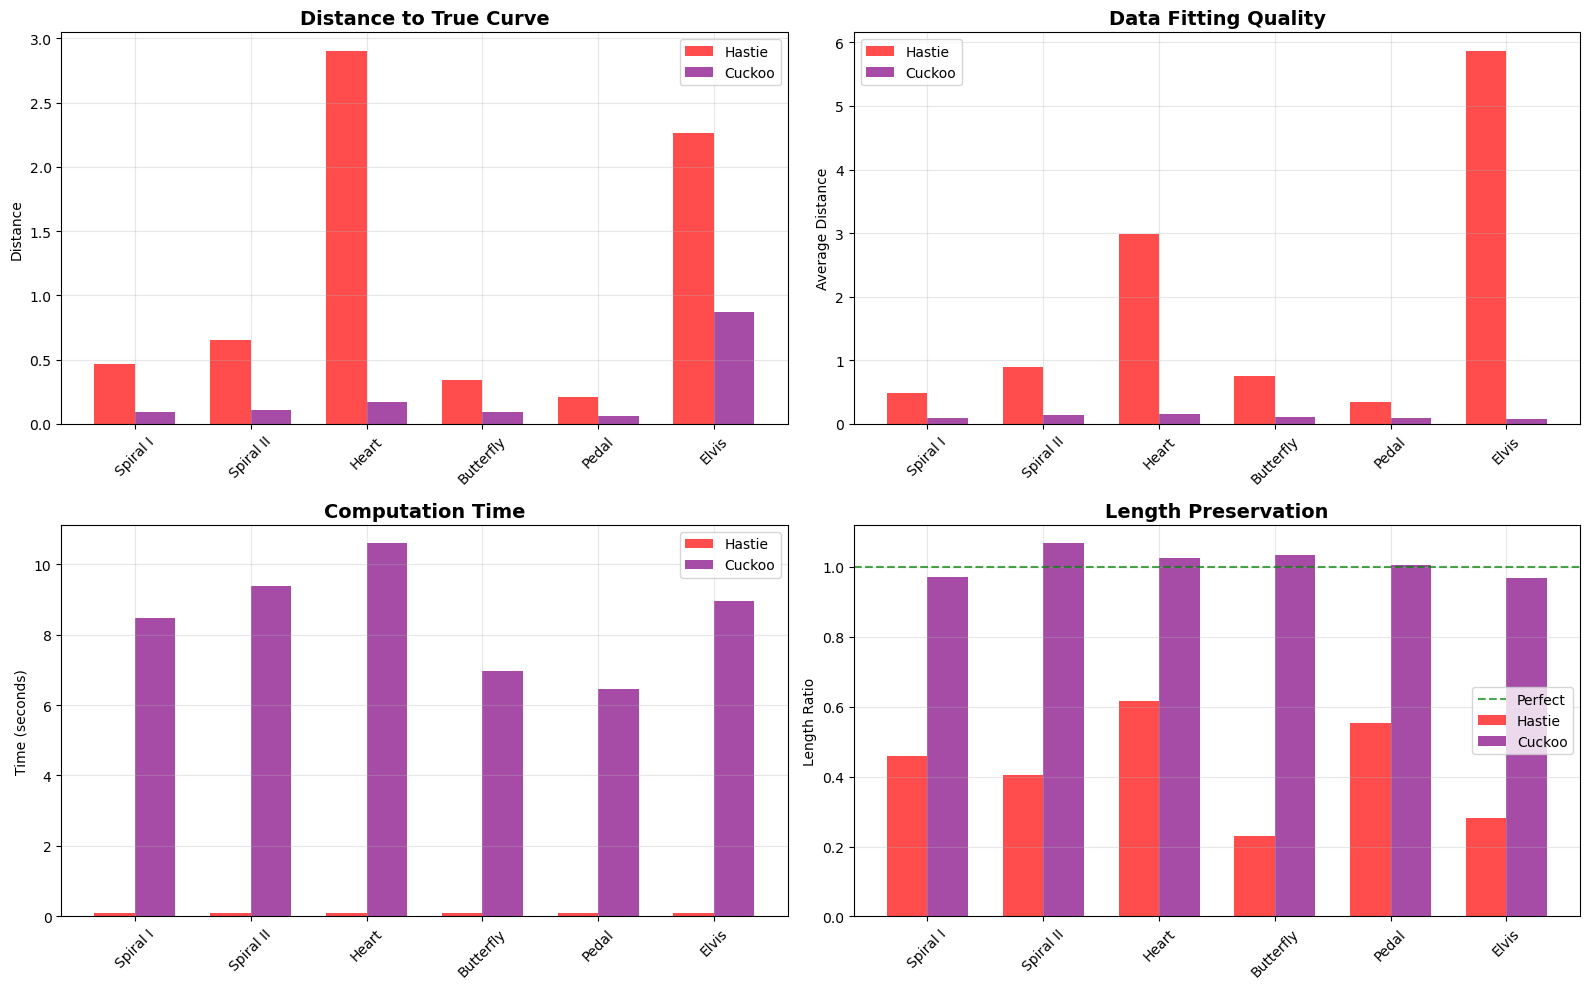

In [65]:
# Cell 9: Performance comparison bar charts
scenarios_list = list(results.keys())

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distance to True Curve
ax = axes[0, 0]
hastie_vals = [results[s]['metrics']['hastie_to_true'] for s in scenarios_list]
cuckoo_vals = [results[s]['metrics']['cuckoo_to_true'] for s in scenarios_list]
x = np.arange(len(scenarios_list))
width = 0.35

ax.bar(x - width/2, hastie_vals, width, label='Hastie', color='red', alpha=0.7)
ax.bar(x + width/2, cuckoo_vals, width, label='Cuckoo', color='purple', alpha=0.7)
ax.set_title('Distance to True Curve', fontsize=14, weight='bold')
ax.set_ylabel('Distance')
ax.set_xticks(x)
ax.set_xticklabels(scenarios_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Data Fitting Quality
ax = axes[0, 1]
hastie_vals = [results[s]['metrics']['hastie_data_fit'] for s in scenarios_list]
cuckoo_vals = [results[s]['metrics']['cuckoo_data_fit'] for s in scenarios_list]

ax.bar(x - width/2, hastie_vals, width, label='Hastie', color='red', alpha=0.7)
ax.bar(x + width/2, cuckoo_vals, width, label='Cuckoo', color='purple', alpha=0.7)
ax.set_title('Data Fitting Quality', fontsize=14, weight='bold')
ax.set_ylabel('Average Distance')
ax.set_xticks(x)
ax.set_xticklabels(scenarios_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Computation Time
ax = axes[1, 0]
hastie_vals = [results[s]['hastie_time'] for s in scenarios_list]
cuckoo_vals = [results[s]['cuckoo_time'] for s in scenarios_list]

ax.bar(x - width/2, hastie_vals, width, label='Hastie', color='red', alpha=0.7)
ax.bar(x + width/2, cuckoo_vals, width, label='Cuckoo', color='purple', alpha=0.7)
ax.set_title('Computation Time', fontsize=14, weight='bold')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Length Preservation
ax = axes[1, 1]
hastie_vals = [results[s]['metrics']['hastie_length_ratio'] for s in scenarios_list]
cuckoo_vals = [results[s]['metrics']['cuckoo_length_ratio'] for s in scenarios_list]

ax.bar(x - width/2, hastie_vals, width, label='Hastie', color='red', alpha=0.7)
ax.bar(x + width/2, cuckoo_vals, width, label='Cuckoo', color='purple', alpha=0.7)
ax.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Perfect')
ax.set_title('Length Preservation', fontsize=14, weight='bold')
ax.set_ylabel('Length Ratio')
ax.set_xticks(x)
ax.set_xticklabels(scenarios_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.show()  
# Save figure with high DPI
plt.savefig("/Users/elviscui/Downloads/performance_comparison.png", dpi=300, bbox_inches='tight')


## 10. Summary Report

In [41]:
# Cell 10: Summary report
print("\n" + "="*80)
print("Summary Report: Hastie & Stuetzle vs PSO (Particle Swarm Optimization)")
print("="*80)

hastie_wins = 0
pso_wins = 0

for name, result in results.items():
    metrics = result['metrics']
    
    hastie_better = 0
    pso_better = 0
    
    # Compare main metrics
    if metrics['hastie_to_true'] < metrics['pso_to_true']:
        hastie_better += 1
    else:
        pso_better += 1
        
    if metrics['hastie_data_fit'] < metrics['pso_data_fit']:
        hastie_better += 1
    else:
        pso_better += 1
    
    if hastie_better > pso_better:
        hastie_wins += 1
        winner = "Hastie"
    elif pso_better > hastie_better:
        pso_wins += 1
        winner = "PSO"
    else:
        winner = "Tie"
    
    print(f"{name:<12}: {winner}")

print("-"*80)
print(f"Overall Results:")
print(f"Hastie wins: {hastie_wins}/{len(results)} scenarios")
print(f"PSO wins: {pso_wins}/{len(results)} scenarios")
print(f"Ties: {len(results) - hastie_wins - pso_wins}/{len(results)} scenarios")

# Average performance
avg_hastie_time = np.mean([r['hastie_time'] for r in results.values()])
avg_pso_time = np.mean([r['pso_time'] for r in results.values()])

print(f"\nAverage computation time:")
print(f"Hastie: {avg_hastie_time:.3f}s")
print(f"PSO: {avg_pso_time:.3f}s")

print(f"\nSpeed advantage: {'Hastie' if avg_hastie_time < avg_pso_time else 'PSO'} "
      f"is faster by {abs(avg_hastie_time - avg_pso_time):.3f}s")

print(f"\nMethod characteristics:")
print(f"Hastie & Stuetzle: Classical statistical method, PCA-based initialization")
print(f"PSO: Swarm intelligence optimization, strong global search capability")
print("="*80)


Summary Report: Hastie & Stuetzle vs PSO (Particle Swarm Optimization)
Spiral I    : PSO
Spiral II   : PSO
Heart       : PSO
Butterfly   : PSO
Pedal       : PSO
Elvis       : Tie
--------------------------------------------------------------------------------
Overall Results:
Hastie wins: 0/6 scenarios
PSO wins: 5/6 scenarios
Ties: 1/6 scenarios

Average computation time:
Hastie: 0.565s
PSO: 0.844s

Speed advantage: Hastie is faster by 0.279s

Method characteristics:
Hastie & Stuetzle: Classical statistical method, PCA-based initialization
PSO: Swarm intelligence optimization, strong global search capability
